# Перенос стиля c tf.keras и классифицирующей сетью VGG19

[Отсюда](https://colab.research.google.com/github/tensorflow/models/blob/master/research/nst_blogpost/4_Neural_Style_Transfer_with_Eager_Execution.ipynb)

## Обзор



<div style="float:left; margin:20px 15px 0px 0px;"><img src='the-godfather-don-vito-corleone-prisma-app.jpg' width="400"><br><a href="https://buzzkid.net/movie-scenes-art-prisma-app/"> - BuzzKid</a></div>

Основная статья по **neural style transfer**: [Leon A. Gatys, A Neural Algorithm of Artistic Style](https://arxiv.org/abs/1508.06576) (2015).

Участвуют три изображения: **содержание** (content), **стилевой образец** (style reference), и **входное изображение**, к которому мы хотим применить стиль. Оптимизируется не сеть, а входное изображение, так чтобы оно содержало то, что на 
содержании, но в стиле заданного образца.

Пример: Возьмем фото пасущейся зеленой морской черепахи и "Большую волну в Канагаве" Хокусая.

<table>
    <tr>
        <td>
<img src="https://github.com/tensorflow/models/blob/master/research/nst_blogpost/Green_Sea_Turtle_grazing_seagrass.jpg?raw=1" alt="Drawing" style="height: 200px;"/></td><td>
<img src="https://github.com/tensorflow/models/blob/master/research/nst_blogpost/The_Great_Wave_off_Kanagawa.jpg?raw=1" alt="Drawing" style="height: 200px;"/></td>
    </tr>
</table>

[Image of Green Sea Turtle, P.Lindgren, Wikimedia Commons](https://commons.wikimedia.org/wiki/File:Green_Sea_Turtle_grazing_seagrass.jpg)<br>
[The Great Wave off Kanagawa, Wikimedia Commons](https://commons.wikimedia.org/wiki/File:The_Great_Wave_off_Kanagawa.jpg)



Как бы Хокусай нарисовал эту черепаху? Типа так:
<img src="https://github.com/tensorflow/models/blob/master/research/nst_blogpost/wave_turtle.png?raw=1" alt="Drawing" style="width: 500px;"/>

Определяем две функции расстояния между изображениями, $L_{content}$ и $L_{style}$. Изменяя входное изображение, стараемся минимизировать расстояние содержания с картинкой содержания и расстояние стиля с картинкой стилевого образца при помощи бэкпропа.


### Ключевые понятия

* **Eager Execution** - режим немедленных вычислений в TensorFlow
* ** [Functional API](https://keras.io/getting-started/functional-api-guide/) в Keras для извлечения промежуточных активаций
* **Использование отображений признаков готовой модели** 
* **Кастомные циклы обучения** - чтобы использовать оптимизацию для уменьшений потерь путем изменения входных параметров

### Шаги

1. Визуализируем
2. Подготовка данных
3. Функции потерь
4. Создание модели
5. Оптимизация

### Ссылки
* Рекомендется держать статью Гатиса под рукой
* [Understand reducing loss with gradient descent](https://developers.google.com/machine-learning/crash-course/reducing-loss/gradient-descent) Хорошее объяснение за градиентный спуск


## Setup

### Import and configure modules

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10,10)
mpl.rcParams['axes.grid'] = False

import numpy as np
from PIL import Image
import time
import functools

import tensorflow as tf
import tensorflow.contrib.eager as tfe

from tensorflow.python.keras.preprocessing import image as kp_image
from tensorflow.python.keras import models 
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K

We’ll begin by enabling [eager execution](https://www.tensorflow.org/guide/eager). Eager execution allows us to work through this technique in the clearest and most readable way. 

In [2]:
tf.enable_eager_execution()
print("Eager execution: {}".format(tf.executing_eagerly()))

Eager execution: True


## Visualize the input

In [3]:
# Set up some global values here
content_path = './Green_Sea_Turtle_grazing_seagrass.jpg'
style_path = './The_Great_Wave_off_Kanagawa.jpg'

def load_img(path_to_img):
  max_dim = 512
  img = Image.open(path_to_img)
  long = max(img.size)
  scale = max_dim/long
  img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS)
  
  img = kp_image.img_to_array(img)
  
  # We need to broadcast the image array such that it has a batch dimension 
  img = np.expand_dims(img, axis=0)
  return img

def imshow(img, title=None):
  # Remove the batch dimension
  out = np.squeeze(img, axis=0)
  # Normalize for display 
  out = out.astype('uint8')
  plt.imshow(out)
  if title is not None:
    plt.title(title)
  plt.imshow(out)

These are input content and style images. We hope to "create" an image with the content of our content image, but with the style of the style image. 

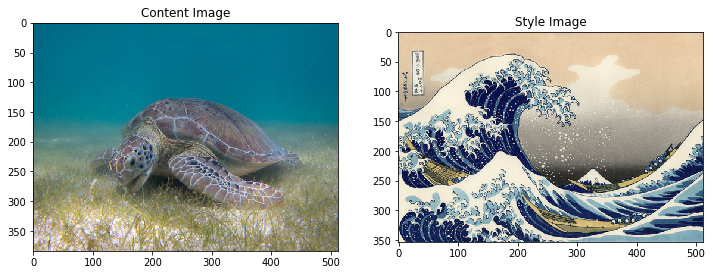

In [4]:
plt.figure(figsize=(12,10))

content = load_img(content_path).astype('uint8')
style = load_img(style_path).astype('uint8')

plt.subplot(1, 2, 1)
imshow(content, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style, 'Style Image')
plt.show()

## Prepare the data
Let's create methods that will allow us to load and preprocess our images easily. We perform the same preprocessing process as are expected according to the VGG training process. VGG networks are trained on image with each channel normalized by `mean = [103.939, 116.779, 123.68]`and with channels BGR.

In [22]:
def load_and_process_img(path_to_img):
    img = load_img(path_to_img)
    img = tf.keras.applications.vgg19.preprocess_input(img)
    return img

In order to view the outputs of our optimization, we are required to perform the inverse preprocessing step. Furthermore, since our optimized image may take its values anywhere between $- \infty$ and $\infty$, we must clip to maintain our values from within the 0-255 range.   

In [24]:
def deprocess_img(processed_img):
    x = processed_img.copy()
    if len(x.shape) == 4:
        x = np.squeeze(x, 0)
    assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")
    if len(x.shape) != 3:
        raise ValueError("Invalid input to deprocessing image")

    # perform the inverse of the preprocessiing step
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]

    x = np.clip(x, 0, 255).astype('uint8')
    return x

## Build the Model 

### Представления стиля и содержания 
Чтобы получить представления содержания и стиля, мы посмотрим на промежуточные скрытые слои модели. Чем дальше слой, том более высокого порядка  признаки находятся на нем. Мы используем модель архитектуры VGG19. Это уже обученная сеть классификации изображений. Промежуточные слои нам нужны, чтобы доставать из них стиль и содержание и приближать их к  значениям для соответствующих отображений.

Диаграмма архитектуры VGG19:
<table><tr><td>
<img src = './llustration-of-the-network-architecture-of-VGG-19-model-conv-means-convolution-FC-means.jpg'>
<td>
<img src = 'The-architecture-of-VGG-19-The-left-part-in-Building-Blocks-indicates-the-size-of.png' style="height:344px">
</table>

#### Почему промежуточные слои?

Почему слои VGG19 позволят определять стиль и содержание? "Размахивая руками", это можно объяснить так: для того, чтобы сеть выполняла классификацию изображений (на что она и обучена), она должна понимать изображение. Это подразумевает переход от входных данных до внутреннего представления, с постепенным превращением необработанных пикселей изображения в сложное понимание признаков, присутствующих в изображении. Cверточные нейронные сети могут хорошо обобщать: они способны улавливать инварианты и определять характеристики в классах (например, кошки против собак), которые не зависят от фонового шума и других неприятностей. Таким образом, где-то между местом подачи необработанного изображения и выводом метки классификации модель можно рассматривать как извлекатель сложных признаков; следовательно, получая доступ к промежуточным слоям, мы можем описать содержание и стиль входных изображений.

Именно, мы получим следующие слои модели: 

In [27]:
# Content layer where will pull our feature maps
content_layers = ['block5_conv2'] 

# Style layer we are interested in
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In this case, we load [VGG19](https://keras.io/applications/#vgg19), and feed in our input tensor to the model. This will allow us to extract the feature maps (and subsequently the content and style representations) of the content, style, and generated images.

We use VGG19, as suggested in the paper. In addition, since VGG19 is a relatively simple model (compared with ResNet, Inception, etc) the feature maps actually work better for style transfer. 

In order to access the intermediate layers corresponding to our style and content feature maps, we get the corresponding outputs and using the Keras [**Functional API**](https://keras.io/getting-started/functional-api-guide/), we define our model with the desired output activations. 

With the Functional API defining a model simply involves defining the input and output: 

`model = Model(inputs, outputs)`

In [25]:
def get_model():
    """ Creates our model with access to intermediate layers. 

    This function will load the VGG19 model and access the intermediate layers. 
    These layers will then be used to create a new model that will take input image
    and return the outputs from these intermediate layers from the VGG model. 

    Returns:
    returns a keras model that takes image inputs and outputs the style and 
      content intermediate layers. 
    """
    # Load our model. We load pretrained VGG, trained on imagenet data
    vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    # Get output layers corresponding to style and content layers 
    style_outputs = [vgg.get_layer(name).output for name in style_layers]
    content_outputs = [vgg.get_layer(name).output for name in content_layers]
    model_outputs = style_outputs + content_outputs
    # Build model 
    return models.Model(vgg.input, model_outputs)

In the above code snippet, we’ll load our pretrained image classification network. Then we grab the layers of interest as we defined earlier. Then we define a Model by setting the model’s inputs to an image and the outputs to the outputs of the style and content layers. In other words, we created a model that will take an input image and output the content and style intermediate layers! 


## Define and create our loss functions (content and style distances)

### Расстояние по содержанию

Передаем нашей сети картинку содержания и нашу входную картинку, на выходе слоя содержания получаем два тензора, между которыми вычислим квадрат евклидова расстояния. Потом будем стараться уменьшить его, изменяя входное изображение и делая бэкпроп.

Кстати, в eager режиме вычисление выхода модели на заданном входе просто сводится к `model(input_image)`, ура!. При этом будут подсчитаны и градиенты 

In [10]:
def get_content_loss(base_content, target):
  return tf.reduce_mean(tf.square(base_content - target))

## Расстояние по стилю

Вычисление функции потерь по стилю немного сложнее: мы сравниваем не сами ответы промежуточных слоев на наши изображения, а матрицы Грама.

Для входного изображения $x$ и стилевого образца $a$ функция потерь будет расстоянием между стилевыми представлениями, где *стилевым представлением* (style representation) изображения назовем матрицу Грама, в некотом смыссле корреляцию ответов разных фильтров: $G^l$, где  $G^l_{ij}$ скалярное произведение векторов признаков $i$ и $j$ в слое $l$. Потом будет градиентный спуск.

Вклад каждого слоя $l$ в стилевую функцию потерь выглядит как
$$E_l = \frac{1}{4N_l^2M_l^2} \sum_{i,j}(G^l_{ij} - A^l_{ij})^2$$
где $G^l_{ij}$ и $A^l_{ij}$ стилевые представления $x$ и $a$, соответственно, в слое $l$. $N_l$ число отображений (карт) признаков, каждая размера $M_l = height \times width$. Все суммируем по слоям:
$$L_{style}(a, x) = \sum_{l \in L} w_l E_l$$
Можно взвешивать каждый слой $w_l$. Пока мы для простоты берем равные веса, $w_l =\frac{1}{|L|}$.

In [28]:
def gram_matrix(input_tensor):
    # We make the image channels first 
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram / tf.cast(n, tf.float32)

def get_style_loss(base_style, gram_target):
    """Expects two images of dimension h, w, c"""
    # height, width, num filters of each layer
    # We scale the loss at a given layer by the size of the feature map and the number of filters
    height, width, channels = base_style.get_shape().as_list()
    gram_style = gram_matrix(base_style)

    return tf.reduce_mean(tf.square(gram_style - gram_target))# / (4. * (channels ** 2) * (width * height) ** 2)

We’ll define a little helper function that will load our content and style image, feed them forward through our network, which will then output the content and style feature representations from our model. 

In [11]:
def get_feature_representations(model, content_path, style_path):
    # returns the style features and the content features, in that order

    # batch compute content and style features for our two files
    content_image = load_and_process_img(content_path)
    style_image = load_and_process_img(style_path)
    style_outputs = model(style_image)
    content_outputs = model(content_image)

    # Get the style and content feature representations from our model  
    style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
    content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]
    return style_features, content_features

## Apply style transfer to our images

### Gradient Descent
If you aren't familiar with gradient descent/backpropagation or need a refresher, you should definitely check out this [awesome resource](https://developers.google.com/machine-learning/crash-course/reducing-loss/gradient-descent).

In this case, we use the [Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam)* optimizer in order to minimize our loss. We iteratively update our output image such that it minimizes our loss: we don't update the weights associated with our network, but instead we train our input image to minimize loss. In order to do this, we must know how we calculate our loss and gradients. 

\* Note that L-BFGS, which if you are familiar with this algorithm is recommended, isn’t used in this tutorial because a primary motivation behind this tutorial was to illustrate best practices with eager execution, and, by using Adam, we can demonstrate the autograd/gradient tape functionality with custom training loops.

### Computing the loss and gradients
Here we use [**tf.GradientTape**](https://www.tensorflow.org/programmers_guide/eager#computing_gradients) to compute the gradient. It allows us to take advantage of the automatic differentiation available by tracing operations for computing the gradient later. It records the operations during the forward pass and then is able to compute the gradient of our loss function with respect to our input image for the backwards pass.

In [12]:
def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
  """This function will compute the loss total loss.
  
  Arguments:
    model: The model that will give us access to the intermediate layers
    loss_weights: The weights of each contribution of each loss function. 
      (style weight, content weight, and total variation weight)
    init_image: Our initial base image. This image is what we are updating with 
      our optimization process. We apply the gradients wrt the loss we are 
      calculating to this image.
    gram_style_features: Precomputed gram matrices corresponding to the 
      defined style layers of interest.
    content_features: Precomputed outputs from defined content layers of 
      interest.
      
  Returns:
    returns the total loss, style loss, content loss, and total variational loss
  """
  style_weight, content_weight = loss_weights
  
  # Feed our init image through our model. This will give us the content and 
  # style representations at our desired layers. Since we're using eager
  # our model is callable just like any other function!
  model_outputs = model(init_image)
  
  style_output_features = model_outputs[:num_style_layers]
  content_output_features = model_outputs[num_style_layers:]
  
  style_score = 0
  content_score = 0

  # Accumulate style losses from all layers
  # Here, we equally weight each contribution of each loss layer
  weight_per_style_layer = 1.0 / float(num_style_layers)
  for target_style, comb_style in zip(gram_style_features, style_output_features):
    style_score += weight_per_style_layer * get_style_loss(comb_style[0], target_style)
    
  # Accumulate content losses from all layers 
  weight_per_content_layer = 1.0 / float(num_content_layers)
  for target_content, comb_content in zip(content_features, content_output_features):
    content_score += weight_per_content_layer* get_content_loss(comb_content[0], target_content)
  
  style_score *= style_weight
  content_score *= content_weight

  # Get total loss
  loss = style_score + content_score 
  return loss, style_score, content_score

Then computing the gradients is easy:

In [13]:
def compute_grads(cfg):
  with tf.GradientTape() as tape: 
    all_loss = compute_loss(**cfg)
  # Compute gradients wrt input image
  total_loss = all_loss[0]
  return tape.gradient(total_loss, cfg['init_image']), all_loss

In [20]:
model = get_model()
for layer in model.layers:
    layer.trainable = False
init_image = load_and_process_img(content_path)
content_image = load_and_process_img(content_path)
style_image = load_and_process_img(style_path)

def runnet():
    style_outputs = model(style_image)
    content_outputs = model(content_image)
    return style_outputs, content_outputs

%timeit A = runnet() # 7.5 с на моем ноуте

A = runnet()

7.79 s ± 300 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [29]:
A = runnet()

### Optimization loop

In [ ]:
import IPython.display

def run_style_transfer(content_path, 
                       style_path,
                       num_iterations=1000,
                       content_weight=1e3, 
                       style_weight=1e-2): 
  # We don't need to (or want to) train any layers of our model, so we set their
  # trainable to false. 
  model = get_model() 
  for layer in model.layers:
    layer.trainable = False
  
  # Get the style and content feature representations (from our specified intermediate layers) 
  style_features, content_features = get_feature_representations(model, content_path, style_path)
  gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]
  
  # Set initial image
  init_image = load_and_process_img(content_path)
  init_image = tfe.Variable(init_image, dtype=tf.float32)
  # Create our optimizer
  opt = tf.train.AdamOptimizer(learning_rate=5, beta1=0.99, epsilon=1e-1)

  # For displaying intermediate images 
  iter_count = 1
  
  # Store our best result
  best_loss, best_img = float('inf'), None
  
  # Create a nice config 
  loss_weights = (style_weight, content_weight)
  cfg = {
      'model': model,
      'loss_weights': loss_weights,
      'init_image': init_image,
      'gram_style_features': gram_style_features,
      'content_features': content_features
  }
    
  # For displaying
  num_rows = 2
  num_cols = 5
  display_interval = num_iterations/(num_rows*num_cols)
  start_time = time.time()
  global_start = time.time()
  
  norm_means = np.array([103.939, 116.779, 123.68])
  min_vals = -norm_means
  max_vals = 255 - norm_means   
  
  imgs = []
  for i in range(num_iterations):
    grads, all_loss = compute_grads(cfg)
    loss, style_score, content_score = all_loss
    opt.apply_gradients([(grads, init_image)])
    clipped = tf.clip_by_value(init_image, min_vals, max_vals)
    init_image.assign(clipped)
    end_time = time.time() 
    
    if loss < best_loss:
      # Update best loss and best image from total loss. 
      best_loss = loss
      best_img = deprocess_img(init_image.numpy())

    if i % display_interval== 0:
      start_time = time.time()
      
      # Use the .numpy() method to get the concrete numpy array
      plot_img = init_image.numpy()
      plot_img = deprocess_img(plot_img)
      imgs.append(plot_img)
      IPython.display.clear_output(wait=True)
      IPython.display.display_png(Image.fromarray(plot_img))
      print('Iteration: {}'.format(i))        
      print('Total loss: {:.4e}, ' 
            'style loss: {:.4e}, '
            'content loss: {:.4e}, '
            'time: {:.4f}s'.format(loss, style_score, content_score, time.time() - start_time))
  print('Total time: {:.4f}s'.format(time.time() - global_start))
  IPython.display.clear_output(wait=True)
  plt.figure(figsize=(14,4))
  for i,img in enumerate(imgs):
      plt.subplot(num_rows,num_cols,i+1)
      plt.imshow(img)
      plt.xticks([])
      plt.yticks([])
      
  return best_img, best_loss 

In [ ]:
best, best_loss = run_style_transfer(content_path, 
                                     style_path, num_iterations=1000)

In [ ]:
Image.fromarray(best)

To download the image from Colab uncomment the following code:

In [ ]:
#from google.colab import files
#files.download('wave_turtle.png')

## Visualize outputs
We "deprocess" the output image in order to remove the processing that was applied to it. 

In [ ]:
def show_results(best_img, content_path, style_path, show_large_final=True):
  plt.figure(figsize=(10, 5))
  content = load_img(content_path) 
  style = load_img(style_path)

  plt.subplot(1, 2, 1)
  imshow(content, 'Content Image')

  plt.subplot(1, 2, 2)
  imshow(style, 'Style Image')

  if show_large_final: 
    plt.figure(figsize=(10, 10))

    plt.imshow(best_img)
    plt.title('Output Image')
    plt.show()

In [ ]:
show_results(best, content_path, style_path)

## Try it on other images
Image of Tuebingen 

Photo By: Andreas Praefcke [GFDL (http://www.gnu.org/copyleft/fdl.html) or CC BY 3.0  (https://creativecommons.org/licenses/by/3.0)], from Wikimedia Commons

### Starry night + Tuebingen

In [ ]:
best_starry_night, best_loss = run_style_transfer('./Tuebingen_Neckarfront.jpg',
                                                  './1024px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg')

In [ ]:
show_results(best_starry_night, './Tuebingen_Neckarfront.jpg',
             './1024px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg')

### Pillars of Creation + Tuebingen

In [ ]:
best_poc_tubingen, best_loss = run_style_transfer('./Tuebingen_Neckarfront.jpg', 
                                                  './Pillars_of_creation_2014_HST_WFC3-UVIS_full-res_denoised.jpg')

In [ ]:
show_results(best_poc_tubingen, 
             './Tuebingen_Neckarfront.jpg',
             './Pillars_of_creation_2014_HST_WFC3-UVIS_full-res_denoised.jpg')

### Kandinsky Composition 7 + Tuebingen

In [ ]:
best_kandinsky_tubingen, best_loss = run_style_transfer('./Tuebingen_Neckarfront.jpg', 
                                                  './Vassily_Kandinsky,_1913_-_Composition_7.jpg')

In [ ]:
show_results(best_kandinsky_tubingen, 
             './Tuebingen_Neckarfront.jpg',
             './Vassily_Kandinsky,_1913_-_Composition_7.jpg')

### Pillars of Creation + Sea Turtle

In [ ]:
!wget --quiet https://upload.wikimedia.org/wikipedia/commons/6/68/Pillars_of_creation_2014_HST_WFC3-UVIS_full-res_denoised.jpg
best_poc_turtle, best_loss = run_style_transfer('./Green_Sea_Turtle_grazing_seagrass.jpg', 
                                                  './Pillars_of_creation_2014_HST_WFC3-UVIS_full-res_denoised.jpg')

In [ ]:
show_results(best_poc_turtle, 
             './Green_Sea_Turtle_grazing_seagrass.jpg',
             './Pillars_of_creation_2014_HST_WFC3-UVIS_full-res_denoised.jpg')

## Key Takeaways

### What we covered:

* We built several different loss functions and used backpropagation to transform our input image in order to minimize these losses
  * In order to do this we had to load in a **pretrained model** and use its learned feature maps to describe the content and style representation of our images.
    * Our main loss functions were primarily computing the distance in terms of these different representations
* We implemented this with a custom model and **eager execution**
  * We built our custom model with the Functional API 
  * Eager execution allows us to dynamically work with tensors, using a natural python control flow
  * We manipulated tensors directly, which makes debugging and working with tensors easier. 
* We iteratively updated our image by applying our optimizers update rules using **tf.gradient**. The optimizer minimized a given loss with respect to our input image. 


**[Image of Tuebingen](https://commons.wikimedia.org/wiki/File:Tuebingen_Neckarfront.jpg)** 
Photo By: Andreas Praefcke [GFDL (http://www.gnu.org/copyleft/fdl.html) or CC BY 3.0  (https://creativecommons.org/licenses/by/3.0)], from Wikimedia Commons

**[Image of Green Sea Turtle](https://commons.wikimedia.org/wiki/File:Green_Sea_Turtle_grazing_seagrass.jpg)**
By P.Lindgren [CC BY-SA 3.0 (https://creativecommons.org/licenses/by-sa/3.0)], from Wikimedia Commons

